In [1]:
import numpy as np
import glob
import json
import os

import matplotlib as mpl
font = {'family' : 'sans',
        'size'   : 12}

mpl.rc('font', **font)
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, LogLocator, MaxNLocator
from scipy.interpolate import PchipInterpolator
import matplotlib.pyplot as plt

import pandas as pd
from cmcrameri import cm


In [18]:
from proteus.config import read_config
from proteus.utils.constants import R_earth
import utils.load_grid as lg

In [3]:
%matplotlib inline
# %config InlineBackend.figure_format='retina'

# %matplotlib widget

In [30]:
def readrun(f, stride=1):
    jsons = glob.glob(f+"/data/*.json")
    if len(jsons) == 0:
        raise Exception("No files found!")

    years = [float(s.split("/")[-1].split(".")[0]) for s in jsons]

    if stride < 0:
        mask = [np.argsort(years)[-1]]
    else:
        mask = np.argsort(years)[::int(stride)]

    jsons = np.array([jsons[i] for i in mask])
    years = np.array([years[i] for i in mask])
    data  = np.array([lg.readjson(f) for f in jsons])

    return years, data

def read_helpfile(fpath):
    return pd.read_csv(fpath, sep=r'\s+')



### Do analysis

In [44]:
def load_grid(pgrid_dir):

    globber = pgrid_dir + "/case_*/"
    print(globber)
    cases = glob.glob(globber)

    npoints = len(cases)
    print("npoints = %d"%npoints)
    if npoints < 1:
        raise

    out = {
        "data": [],
        "conf": [],
        "cnum": [],
        "npts": npoints,
        "pdir": pgrid_dir
    }

    for folder in cases:
        _,d = readrun(folder, stride=-1)
        out["data"].append( d )
        out["conf"].append( read_config(folder+"init_coupler.toml") )
        out["cnum"].append(int(folder.split("_")[-1].replace("/","")))

    print("Done")
    return out



In [45]:
lov_b  = load_grid("data/output/LOV_b/")
lov_c  = load_grid("data/output/LOV_c/")
lov_d  = load_grid("data/output/LOV_d/")

data/output/LOV_b//case_*/
npoints = 100
Done
data/output/LOV_c//case_*/
npoints = 100
Done
data/output/LOV_d//case_*/
npoints = 100
Done


In [46]:
def core_melt(p):
    # pressure [GPa]
    # returns temperature [K]
    return 5530 * ((p - 260)/293 + 1) ** 0.552

Core solid at CMB for: planet LOV_d  where r_c=0.72 and fO2=-2.78
Core solid at CMB for: planet LOV_d  where r_c=0.77 and fO2=-2.78
Core solid at CMB for: planet LOV_d  where r_c=0.81 and fO2=-2.78
Core solid at CMB for: planet LOV_d  where r_c=0.72 and fO2=-1.67
Core solid at CMB for: planet LOV_d  where r_c=0.77 and fO2=-1.67
Core solid at CMB for: planet LOV_d  where r_c=0.81 and fO2=-1.67
Core solid at CMB for: planet LOV_d  where r_c=0.72 and fO2=-0.56
Core solid at CMB for: planet LOV_d  where r_c=0.77 and fO2=-0.56
Core solid at CMB for: planet LOV_d  where r_c=0.81 and fO2=-0.56
Core solid at CMB for: planet LOV_d  where r_c=0.72 and fO2=5.00


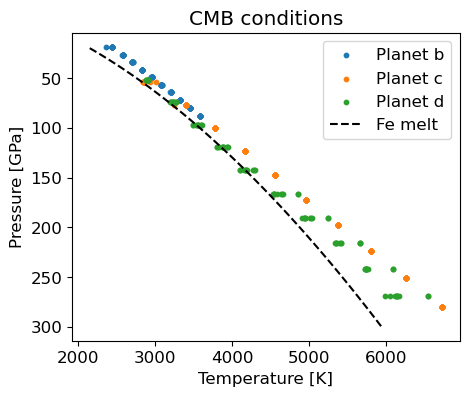

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))

cols = ('tab:blue','tab:orange','tab:green')
for i,lov in enumerate((lov_b, lov_c, lov_d)):
    for j in range(lov["npts"]):
        if j == 0:
            lb = "Planet "+lov["pdir"][:-1].split("_")[-1]
        else:
            lb = ""
        ds = lov["data"][j][-1]
        x = ds["temp_s"]
        y = ds["pressure_s"] / 1e9
        ax.scatter(x[-1],y[-1], color=cols[i], s=10, label=lb)

        if x[-1] < core_melt(y[-1]):
            rc = lg.descend_get(lov["conf"][j], "struct.corefrac")
            fo = lg.descend_get(lov["conf"][j], "outgas.fO2_shift_IW")
            print("Core solid at CMB for: planet "+lov["pdir"].split("/")[-2], " where r_c=%.2f and fO2=%.2f"%(rc,fo))

p_arr = np.linspace(20,300,100)
ax.plot(core_melt(p_arr),p_arr, color='k', ls='dashed', label="Fe melt")

ax.invert_yaxis()
ax.set_ylabel("Pressure [GPa]")
ax.set_xlabel("Temperature [K]")
ax.legend()
ax.set_title("CMB conditions")

plt.show()